Information flow
---

In this section we will simulate *information flow* in a network. Information flow refers to how a piece of information travels between actors (here, *actors* means people -- not movie stars -- but it could refer to companies, animals, or other agents). We are interested in questions like: how does the size of the network and its structure affect information flow?

The simulation should, of course, seek to model the behaviour of the real-world network we are interested in studying. We do the modelling at the level of nodes. That means we don't write a global, top-down model. Instead we try to express, in code, the behaviour of a single node. 

Our initial scenario is very simple: there is some piece of news, initially known to only one actor. At the first time step, it passes it on to all its friends. At each time step, anyone who hears the news passes it on immediately. We will implement this first, then think about extensions later.

We represent this in Pregel as follows. Each node has a state representing whether or not it has heard the news. We could use a Boolean for this. But we will wish to see, during and after the simulation, how quickly the node heard the news. So we will represent the state as an integer: -1 will indicate the node does not yet know the news, and any non-negative integer will represent the time-step at which the node heard the news.

Tangent: `__future__`
---

In Python 2, `print` is a statement, ie we write `print s`. If we write `print(s)`, which looks like a function call, Python 2 will interpret that as `print (s)`, ie `(s)` is just `s` in brackets, which have no effect. If we write `print(s, t)`, that will be interpreted as `print (s, t)`, and the `(s, t)` will be interpreted as a *tuple*. 

This changes in Python 3. In Python 3, `print` must be written as a function, ie `print(s)`, not a statement. `print s` is a SyntaxError.

Python 2 provides a strange-looking import from `__future__`, as you can see below. It changes Python 2 to behave like Python 3, in this respect. If we run the same import in Python 3, it just does nothing.

I sometimes write Python 2 and sometimes Python 3, but I'm mostly moving to 3. In order to force myself to write  code which will run in either 2 or 3, I use this import. 

In [1]:
from __future__ import print_function

Information flow
---

Now we'll import our usual libraries.

In [11]:
from pregel import Vertex, Pregel
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Let's create a Watts-Strogatz network of 100 nodes with 7 out-edges each and probability 0.1 of rewiring. Pregel uses a directed graph, so to model a symmetric relationship (*A* is a friend of *B* implies *B* is a friend of *A*) we create two directed edges for every relationship.

In [43]:
n = 100 # number of nodes
m = 2 # number of edges per node
p = 0.1

def create_graph():
    G = nx.random_graphs.connected_watts_strogatz_graph(n, m, p)
    vertices = [InformationFlowVertex(j, -1, [], []) 
                for j in range(n)]
    for u, v in G.edges():
        vertices[u].out_vertices.append(vertices[v])
        vertices[v].out_vertices.append(vertices[u])
    return vertices


    

Now let's think like a vertex. How should we behave? If we get an incoming message, that means we now know the knowledge, so we can change our state. We can also send it out to all our friends. We can then vote to halt, which also means we'll go to sleep.

In [44]:
class InformationFlowVertex(Vertex):
    def update(self):
        
        if self.superstep == 0 and self.id == 0:
            # special case: we are the first node to know
            self.value = 0
            self.outgoing_messages = [(v,1,True) for v in self.out_vertices]
                
        else:
            # typical case
            if self.value < 0 and len(self.incoming_messages):
                self.value = self.superstep # we learned the information at this time-step
                # if we've just heard, then tell our friends, and
                # then stop processing
                self.outgoing_messages = [(v,1,True) for v in self.out_vertices]

        # regardless of what has happened, we have no more work to do for now 
        self.active = False

How many time-steps should we run? At the most, it could take $n$ steps to propagate to every other node (if the topology is a line). So we'll allow that many.

In [45]:
nsteps = n 

What information would we like to see, while running, or afterward? Let's just record the time-step, the proportion of nodes which know the news, and the proportion which are active. These two numbers will sum to 1, but conceptually they are distinct (in later models they might not sum to 1) so we'll calculate them explicitly.

In [46]:
def stats(vertices):
    superstep = vertices[0].superstep
    n = len(vertices)
    # what proportion of vertices know the piece of news?
    pknow = sum(v.value >= 0 for v in vertices) / float(n)
    pactive = sum(v.active for v in vertices) / float(n)
    return superstep, pknow, pactive

Let's make a function to plot some data from our computation. Let's assume the `stats` function in `pregel.py` will always save a tuple of numbers, in which the superstep is the first number. Then `p.run()` will always return a list of tuples. We can convert that to Numpy, and then plot the second column against the first.

In [47]:
def plot_v_time(ds, ylabel=""):
    for d in ds:
        d = np.array(d)
        plt.plot(d[:, 0], d[:, 1])
    plt.xlabel("Time")
    plt.ylabel(ylabel)

In [48]:
def main():
    vertices = create_graph()
    p = Pregel(vertices, stats_fn=stats)
    p.run()
    return p.data

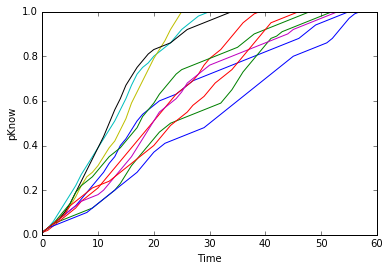

In [49]:
ds = []
for i in range(10):
    ds.append(main())
plot_v_time(ds, "pKnow")

Exercises
---

1. The above simple model effectively duplicates the shortest path computation in an unweighted, undirected network. So, it's not too interesting. What about if there is instead a *probability* of passing a piece of information on to each neighbour at each time-step? We would decide whether to pass it on or not. We wouldn't just go immediately to sleep, unless we were sure we had passed it on to all of our neighbours. Add this feature to the above model, and note the effect of changing the probability value.